In [1]:
import re
import os
import psycopg2
import sqlalchemy
import numpy as np
import pandas as pd
import seaborn as sns
from src.utils import *
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
from sqlalchemy import create_engine,URL
pd.set_option('display.max_columns',40)
pd.set_option('display.float_format','{:.2f}'.format)
load_dotenv();

In [2]:
#Create a reusable function to extract raw excel data from Github and added it to utils.py 
#The extracted raw data from github is saved into the project folder ..\data\01-raw and loaded directly into memory using pandas.

url = "https://raw.githubusercontent.com/LuxDevHQ/CH05_PROJECT_DA-DS/main/Online%20Retail%20Data%20Set.xlsx"
destination = "../data/01-raw"
filename = "Online_Retail_Data_Set.xlsx"
retail_data_set = extract_files(url, destination, filename)
retail_data_set.head(2)

Destination: ..\data\01-raw\Online_Retail_Data_Set.xlsx
Data size: 23,715,344 bytes (22.62 MB)
Success! File 'Online_Retail_Data_Set.xlsx' saved to ../data/01-raw
Loading Excel file into DataFrame...


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom


In [3]:
#The raw data has over 541,000 rows and 8 rows 
def shape(df_):
    print(f"Shape of DataFrame: {df_.shape}")
    return df_
shape(retail_data_set)

Shape of DataFrame: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.00,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.00,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.00,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.00,France


In [4]:
#The .describe() method returns a DataFrame containing summary statistics for all numeric columns
#Pass include ='all' to view other types. We can easily tell the count of the non-missing rows by inspecting count row.
(retail_data_set
.describe(include = 'all')
 )

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909.00,541909,540455,541909.00,541909,541909.00,406829.00,541909
unique,25900.00,4070,4223,NaN,NaN,NaN,NaN,38
top,573585.00,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,NaN,United Kingdom
freq,1114.00,2313,2369,NaN,NaN,NaN,NaN,495478
mean,NaN,NaN,NaN,9.55,2011-07-04 13:34:57.156386048,4.61,15287.69,NaN
min,NaN,NaN,NaN,-80995.00,2010-12-01 08:26:00,-11062.06,12346.00,NaN
25%,NaN,NaN,NaN,1.00,2011-03-28 11:34:00,1.25,13953.00,NaN
50%,NaN,NaN,NaN,3.00,2011-07-19 17:17:00,2.08,15152.00,NaN
75%,NaN,NaN,NaN,10.00,2011-10-19 11:27:00,4.13,16791.00,NaN
max,NaN,NaN,NaN,80995.00,2011-12-09 12:50:00,38970.00,18287.00,NaN


In [5]:
#Some of the columns are not in numeric form and may not lend easily to analysis.
# Additionally, there are missing CustomerID & Description data that also needs to be dealt with
(retail_data_set
 .info(memory_usage='deep')
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 134.9 MB


In [6]:
#We'll create a DataFrame showing the count and percentage of missing values for each column.
(retail_data_set
    .isna()
    .sum()
    .to_frame('missing_count')
    .assign(missing_percentage=lambda df_: (df_.missing_count / len(retail_data_set) * 100).round(2),
        total_rows =  len(retail_data_set))
        
    .sort_values('missing_percentage', ascending=False)
)

,missing_count,missing_percentage,total_rows
CustomerID,135080,24.93,541909
Description,1454,0.27,541909
StockCode,0,0.00,541909
InvoiceNo,0,0.00,541909
Quantity,0,0.00,541909
InvoiceDate,0,0.00,541909
UnitPrice,0,0.00,541909
Country,0,0.00,541909


In [7]:
EXCLUSION_LIST = ['POST','DOT','B','M','C2','D','S','BANK CHARGES','CRUK','AMAZONFEE','DCGSSGIRL','DCGSSBOY','GIFT_0001_10', 'GIFT_0001_20','GIFT_0001_30','GIFT_0001_50','PADS',22016]

STOCK_CODES_DICT =  {'82613C': '82613B','82613A': '82613B','47586A': '47585A', '79192A': '79190A','79191D': '79190D','79191B': '79190B','85024B': '85023B', '81953B': '81952B','35909B':'35910B','10135':'10133'}

JUNK_TEXT = ['CHECK', 'DAMAGED', 'DAMAGES', 'SMASHED', 'MISSING', 'CRUSHED', 'WET', 'RUSTY', 'THROWN AWAY', 'UNSALEABLE', 'STOCK ENTRY', 'ADJUSTMENT', 'REVERSE', 'FOUND', 'TEST',
             'MIXED UP', 'SAMPLES','DOTCOM', 'AMAZON', 'EBAY', 'MAILOUT', 'PUT ASIDE', 'SOLD AS', 'ALAN HODGE','???', '??', '?']
#Data Clean up, Standardization & feature engineering.
def salesDataPreprocessing(df_):
    """  
      1. Convert CustomerID to an Integer and fill missing values with 99999--Sales to non customers.
      2. Convert Unit Price to float and later filter out negative values, these are bad debts that were adjusted.
      3. Convert the InvoiceDate column into a proper datetime format.
      4. Create a new column Cancelled by evaluating InvoiceNo beginning with letter "C".
      5. Create new column called Revenue : Revenue = Quantity * UnitPrice.
      6. Create new fields for Month, Year, Day extracted from InvoiceDate.
      7. Remove duplicates.
      8. Exclude all transactions with negative or zero quantity.
      9. Exclude non-merchandise entries (such as fees, services, discounts, and internal codes) out of sales data for accurate analysis.
      10.Exclude invoice code 22016 along with the others codes like it (e.g., GIFT_0001_XX codes) e.t.c.,
         They should be excluded so that we do not inflate product sales figures as the actual revenue from merchandise will only be recorded
         when the customer redeems the voucher for physical goods.
      11. Resolve the duplicated/inconsistent pricing on the same receipt for the same customer- Calculate the average unit price and consolidate the line item into one single row.
      """
    return (df_
            .drop_duplicates()
            .assign(CustomerID = lambda df_ : df_.CustomerID.astype('Int64').fillna(99999),
            Description = lambda df_: df_.Description.str.upper().str.strip(),
            UnitPrice = lambda df_ : df_.UnitPrice.astype(float),
            InvoiceDate =lambda df_ : pd.to_datetime(df_.InvoiceDate),
            Cancelled = lambda df_ : np.where(df_.InvoiceNo.astype('str').str.contains("C"),"Y","N"),
            GiftVoucher = lambda df_ : np.where(df_.StockCode.astype('str').str.contains("gift_0001"),"Y","N"),
            Revenue =lambda df_ : (df_.Quantity * df_.UnitPrice).round(2),
            Dt_Day =lambda df_ : df_.InvoiceDate.dt.day,
            Dt_Month =lambda df_ : df_.InvoiceDate.dt.month_name(),
            Dt_Year =lambda df_ : df_.InvoiceDate.dt.year,
            #Standardize cases and master StockCodes
            StockCode = lambda df_ : (df_.StockCode.astype(str).str.upper()
                                    .map(STOCK_CODES_DICT)             
                                    .fillna(df_.StockCode)               
                                    .astype(str)                         
                                    .str.upper()))
                                  )

#Create product dictionary mappings
# clean duplicates at invoice level*
def create_product_dict(df_processed):
    return (df_processed
        .assign(StockCode =lambda df_ : df_.StockCode.str.upper(),
                Description = lambda df_: df_.Description.str.upper().str.strip())
        .groupby(['StockCode', 'Description'], as_index=False)
        .agg(num_descriptions = ('Description', 'count'))
        .sort_values(by =['num_descriptions'],ascending=False)
        .drop_duplicates(subset=['StockCode'], keep = 'first')
        .loc[:,["StockCode","Description"]]
        .set_index('StockCode')['Description'].to_dict()
        )
#Apply dictionary and final filters.
def cleanUpRetailSalesData(df_processed, product_dict):
        groupingCols =['InvoiceNo', 'StockCode', 'Description','InvoiceDate', 'CustomerID', 'Country', 'Cancelled', 'GiftVoucher','Dt_Day','Dt_Month', 'Dt_Year']
        regex_pattern = "|".join([re.escape(text) for text in JUNK_TEXT])
        return (df_processed
        #Ckean stock codes accross recipts...
        .assign(StockCode = lambda df_:  df_.StockCode.astype(str).str.upper().map(finalStockCodesClnUp(df_)).fillna(df_.StockCode).astype(str).str.upper())
        #Map description from the dictionary
        .assign(Description = lambda df_: df_.StockCode.map(product_dict).fillna(df_.Description))
        ##Final Filters
        # 1.Remove Negative prices 2. Remove cancellations 3. Exclude ZERO and negative quantities
        .query('UnitPrice > 0 & Cancelled == "N" & Quantity > 0 & GiftVoucher == "N"')
         .assign( is_junk = lambda df: (df['Description'].astype(str).str.upper().str.contains(regex_pattern, case=False, na=False, regex=True)) )
        .query('not is_junk')
        # Filter out non merchandise sales & financial liabilities.
        .query('StockCode not in @EXCLUSION_LIST')
        # Consolidate duplicate line items by summing Quantity and Revenue
        # Recalculate UnitPrice as the weighted average price for the consolidated line
        .groupby(groupingCols,as_index =False)
        .agg(Quantity=('Quantity', 'sum'),Revenue =('Revenue', 'sum'))
        .assign(UnitPrice  = lambda df_ : (df_.Revenue/ df_.Quantity).round(2))
       

    )

def finalStockCodesClnUp(df_):
  dict_df = (df_
      #.query('Description in@product_names')
      .groupby(['StockCode', 'Description'], as_index=False)
      .agg(num_descriptions = ('Description', 'count'))
      .sort_values(by=['Description','num_descriptions'],ascending = [True,False])
      .assign(Key = lambda df: df.groupby('Description')['StockCode'].transform('first'))
      .query('StockCode !=Key'))
  return  dict(zip(dict_df['StockCode'],dict_df['Key']))
    
df_standardized = (salesDataPreprocessing(retail_data_set))
product_dict = (create_product_dict(df_standardized))
clean_sales_df = cleanUpRetailSalesData(df_standardized, product_dict)
shape(clean_sales_df)
clean_sales_df.info()

Shape of DataFrame: (496072, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496072 entries, 0 to 496071
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    496072 non-null  object        
 1   StockCode    496072 non-null  object        
 2   Description  496072 non-null  object        
 3   InvoiceDate  496072 non-null  datetime64[ns]
 4   CustomerID   496072 non-null  Int64         
 5   Country      496072 non-null  object        
 6   Cancelled    496072 non-null  object        
 7   GiftVoucher  496072 non-null  object        
 8   Dt_Day       496072 non-null  int32         
 9   Dt_Month     496072 non-null  object        
 10  Dt_Year      496072 non-null  int32         
 11  Quantity     496072 non-null  int64         
 12  Revenue      496072 non-null  float64       
 13  UnitPrice    496072 non-null  float64       
dtypes: Int64(1), datetime64[ns](1), float64(2), int32(2

**Data Cleaning Operations Summary**

**1. Initial Data Inspection and Preparation**
 - Data Size: The raw dataset contained 541,909 entries across 8 columns.
 - Missing Values Handled: CustomerID: Identified $\sim 24.93\%$ (**135,080 rows**) missing.
 - Description: Identified $\sim 0.27\%$ (**1,454 rows**) missing. These rows were handled to prevent downstream errors.
 - Data Type Conversion: Converted CustomerID from float64 to Int64 (Pandas integer type) to correctly handle missing values and prepare for SQL loading.

 **2. StockCode & Description Standardization**
 - This step focused on creating a clean, one-to-one mapping for the final Ecom_Product dimension table by resolving product name inconsistencies.
 - Issue Addressed: Multiple, slightly different descriptions (e.g., typos, case variations) were associated with the same StockCode (e.g., '82613B', '82613C').
 - Method: Grouped by StockCode and Description to identify codes with multiple descriptions then selected a single canonical description for each StockCode.

 **3. Exclusion of Non-Merchandise Items**
 - The most critical step for sales analysis was defining and filtering out non-product, service, or financial adjustment entries.

| Category              | Description Examples                              | StockCode Examples           | Action   |
|:----------------------|:--------------------------------------------------|:----------------------------|:---------|
| Shipping/Logistics    | POSTAGE, CARRIAGE, DOTCOM POSTAGE                 | POST, C2, DOT               | Excluded |
| Internal Adjustments  | MANUAL, ADJUST BAD DEBT, PADS TO MATCH ALL CUSHIONS | M, B, PADS                  | Excluded |
| Fees/Commissions      | BANK CHARGES, AMAZON FEE, CRUK COMMISSION         | BANK CHARGES, AMAZONFEE, CRUK | Excluded |
| Financial/Vouchers    | Dotcomgiftshop Gift Voucher £XX.00                | GIFT_0001_XX, 22016         | Excluded |
| Samples/Discounts     | SAMPLES, DISCOUNT                                 | S, D                        | Excluded |

**4. Feature engineering**

- Revenue: Derived as (Quantity * UnitPrice).
- Time Components - extracted Month and Year from InvoiceDate column.
- New boolean columns created (Cancelled) for easier filtering:

In [8]:
customers_tbl =(clean_sales_df
 .loc[:,["CustomerID","Country"]]
 .drop_duplicates()
 .reset_index(drop =True)
 #.query('StockCode==23236')
 )
customers_tbl

,CustomerID,Country
0,17850,United Kingdom
1,13047,United Kingdom
2,12583,France
3,13748,United Kingdom
4,15100,United Kingdom
...,...,...
4346,13436,United Kingdom
4347,15520,United Kingdom
4348,13298,United Kingdom
4349,14569,United Kingdom


In [9]:
products_tbl =(clean_sales_df
    .loc[:,["StockCode","Description"]]
    .drop_duplicates()     
   )
products_tbl

,StockCode,Description
0,20694,FLORAL PINK MONSTER
1,21730,GLASS STAR FROSTED T-LIGHT HOLDER
2,22752,SET 7 BABUSHKA NESTING BOXES
3,71053,WHITE METAL LANTERN
4,84029E,RED WOOLLY HOTTIE WHITE HEART.
...,...,...
461004,23561,SET OF 6 RIBBONS PARTY
464393,23609,SET 10 CARDS SNOWY ROBIN 17099
468808,23617,SET 10 CARDS SWIRLY XMAS TREE 17104
482200,90214U,"LETTER ""U"" BLING KEY RING"


In [10]:
fct_sales_tbl =(clean_sales_df
    .loc[:,['InvoiceNo', 'CustomerID','StockCode','Description','InvoiceDate', 'Quantity','UnitPrice','Revenue','Cancelled', 'Dt_Month','Dt_Year', 'Dt_Day','Country']]     
    )
fct_sales_tbl

,InvoiceNo,CustomerID,StockCode,Description,InvoiceDate,Quantity,UnitPrice,Revenue,Cancelled,Dt_Month,Dt_Year,Dt_Day,Country
0,536365,17850,20694,FLORAL PINK MONSTER,2010-12-01 08:26:00,14,2.66,37.30,N,December,2010,1,United Kingdom
1,536365,17850,21730,GLASS STAR FROSTED T-LIGHT HOLDER,2010-12-01 08:26:00,6,4.25,25.50,N,December,2010,1,United Kingdom
2,536365,17850,22752,SET 7 BABUSHKA NESTING BOXES,2010-12-01 08:26:00,2,7.65,15.30,N,December,2010,1,United Kingdom
3,536365,17850,71053,WHITE METAL LANTERN,2010-12-01 08:26:00,6,3.39,20.34,N,December,2010,1,United Kingdom
4,536365,17850,84029E,RED WOOLLY HOTTIE WHITE HEART.,2010-12-01 08:26:00,6,3.39,20.34,N,December,2010,1,United Kingdom
...,...,...,...,...,...,...,...,...,...,...,...,...,...
496067,581587,12680,22730,ALARM CLOCK BAKELIKE IVORY,2011-12-09 12:50:00,4,3.75,15.00,N,December,2011,9,France
496068,581587,12680,22899,CHILDREN'S APRON DOLLY GIRL,2011-12-09 12:50:00,6,2.10,12.60,N,December,2011,9,France
496069,581587,12680,23254,CHILDRENS CUTLERY DOLLY GIRL,2011-12-09 12:50:00,4,4.15,16.60,N,December,2011,9,France
496070,581587,12680,23255,CHILDRENS CUTLERY CIRCUS PARADE,2011-12-09 12:50:00,4,4.15,16.60,N,December,2011,9,France


In [11]:
#Initialize db and perform inserts
db_manager = PostgresClient()

schema = 'online_retail'
configs = [
            { 'df': fct_sales_tbl,
        'schema': schema,
        'table_name': 'ecom_sales_transaction',
        'dtype_map': None 
    },
    { 'df': customers_tbl,
        'schema': schema,
        'table_name': 'ecom_customer',
        'dtype_map': None 
    },

    { 'df': products_tbl,
        'schema': schema,
        'table_name': 'ecom_product',
        'dtype_map': None 
    }

]
[db_manager.insert_dataframe(
    config['df'],
    config['schema'],
    config['table_name'],
    if_exists='replace',
    index=False,
    dtype_map=config['dtype_map']
) for config in configs];


Success. Inserted 496072 records into ecom_sales_transaction table
Success. Inserted 4351 records into ecom_customer table
Success. Inserted 3395 records into ecom_product table


#### **DATA ANALYSIS**

**Insights**
1. **Time Series (2011 Revenue by Month)**

    - Group by month and calculate revenue totals
    - Identify seasonal patterns or month-to-month changes
2. **Country Performance (Excluding United Kingdom)**
    - Rank countries by total revenue
    - Identify the top 10 revenue-generating countries
    - Compute both revenue and quantity sold
3. **Top Customers by Revenue**
    - Rank all customers by total revenue
    - Identify the top 10 highest-spending customers
4. **Global Product Demand**
    - Compute total quantity sold per country
    - Remove the United Kingdom
    - Rank countries by demand and highlight high-opportunity markets

In [12]:
#Filter data for Year = 2011
sqlGet2011 = """  
SELECT * FROM online_retail.ecom_sales_transaction
where "Dt_Year" = 2011
"""
sales_2011 = db_manager.select_data(sqlGet2011)
sales_2011.head()

Query successful. Fetched 458179 rows.


,InvoiceNo,CustomerID,StockCode,Description,InvoiceDate,Quantity,UnitPrice,Revenue,Cancelled,Dt_Month,Dt_Year,Dt_Day,Country
0,540178,12681,21881,CUTE CATS TAPE,2011-01-05 12:42:00,24,0.19,4.56,N,January,2011,5,France
1,540458,12501,21883,STARS GIFT TAPE,2011-01-07 12:28:00,24,0.19,4.56,N,January,2011,7,Germany
2,540469,12484,21677,HEARTS STICKERS,2011-01-07 14:04:00,6,0.85,5.10,N,January,2011,7,Spain
3,540469,12484,21679,SKULLS STICKERS,2011-01-07 14:04:00,6,0.85,5.10,N,January,2011,7,Spain
4,540480,12480,22654,DELUXE SEWING KIT,2011-01-07 15:27:00,3,5.95,17.85,N,January,2011,7,Germany


In [13]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
grouped_rslts = (sales_2011
 .assign(Dt_Month = lambda df: pd.Categorical(df.Dt_Month, categories=month_order, ordered=True))
 .groupby(["Dt_Month"],as_index = False,observed=True).agg(total_revenue = ('Revenue','sum'))
 .assign(MoM_Change = lambda df_ : df_.total_revenue.diff(),
         MoM_Pct_Change = lambda df_ : df_.total_revenue.pct_change() *100,
         Ytd_Revenue = lambda df_ : df_.total_revenue.cumsum(),
         Avg_Revenue = lambda df_ : df_.total_revenue.mean(),
         Variance = lambda df_ : df_.Avg_Revenue - df_.total_revenue,
         Variance_Pct = lambda df_: ((df_.total_revenue / df_.Avg_Revenue) - 1) * 100,
         #Performance indicators
        Above_Average = lambda df_: df_.total_revenue >  df_.Avg_Revenue,
        Revenue_Rank = lambda df_: df_.total_revenue.rank(ascending=False, method='dense').astype(int),
        #Roling 3-months moving average
        Rolling_3M_Avg = lambda df_: df_.total_revenue.rolling(window=3, min_periods=1).mean(),
        #Assign quarter
        Quarter = lambda df_: pd.cut(range(len(df_)), bins=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
         )

)
grouped_rslts

,Dt_Month,total_revenue,MoM_Change,MoM_Pct_Change,Ytd_Revenue,Avg_Revenue,Variance,Variance_Pct,Above_Average,Revenue_Rank,Rolling_3M_Avg,Quarter
0,January,669954.92,NaN,NaN,669954.92,788971.91,119016.99,-15.09,False,9,669954.92,Q1
1,February,507396.38,-162558.54,-24.26,1177351.30,788971.91,281575.53,-35.69,False,12,588675.65,Q1
2,March,689273.34,181876.96,35.85,1866624.64,788971.91,99698.57,-12.64,False,7,622208.21,Q1
3,April,514996.90,-174276.44,-25.28,2381621.54,788971.91,273975.01,-34.73,False,11,570555.54,Q2
4,May,739339.90,224343.00,43.56,3120961.44,788971.91,49632.01,-6.29,False,4,647870.05,Q2
5,June,737271.13,-2068.77,-0.28,3858232.57,788971.91,51700.78,-6.55,False,5,663869.31,Q2
6,July,687758.85,-49512.28,-6.72,4545991.42,788971.91,101213.06,-12.83,False,8,721456.63,Q3
7,August,723843.92,36085.07,5.25,5269835.34,788971.91,65127.99,-8.25,False,6,716291.30,Q3
8,September,1028088.63,304244.71,42.03,6297923.97,788971.91,-239116.72,30.31,True,3,813230.47,Q3
9,October,1103187.72,75099.09,7.30,7401111.69,788971.91,-314215.81,39.83,True,2,951706.76,Q4


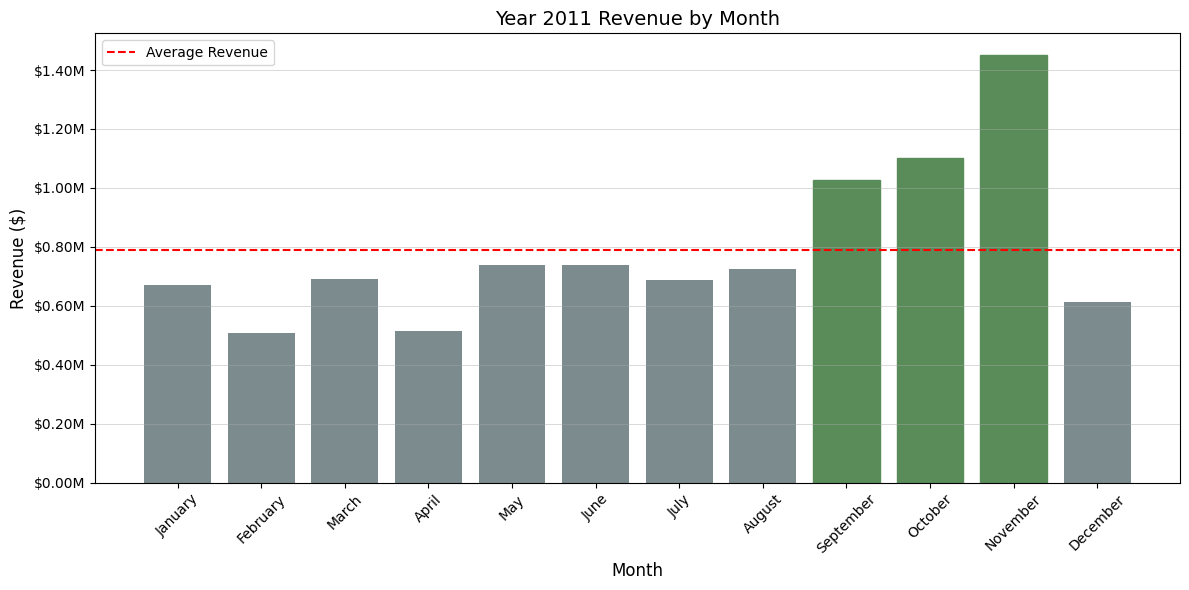

In [14]:
def millions_formatter(x, pos):
    """Format numbers as millions with 'M' suffix"""
    return f'${x/1e6:.2f}M'
#=========================
#custom plotting colors 
BLUE = '#2E5A88'    
GRAY = '#7B8B8E'  
GREEN = '#5A8C5A' 
LIGHT_GRAY = '#F5F5F5'
#==========================
plt.figure(figsize=(12, 6))
bars = plt.bar(grouped_rslts['Dt_Month'], grouped_rslts['total_revenue'], color=GRAY)
#set distinct color for above-average average performance...
for i, (bar, above_avg) in enumerate(zip(bars, grouped_rslts['Above_Average'])):
    if above_avg:
        bar.set_color(GREEN)
plt.axhline(y=grouped_rslts['Avg_Revenue'].iloc[0], color='red', linestyle='--', label='Average Revenue')
plt.title('Year 2011 Revenue by Month', fontsize=14)
plt.xlabel('Month',fontsize=12)
plt.ylabel('Revenue ($)',fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.6, linestyle='-', linewidth=0.5, color='darkgray')

# Apply custom formatter
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.legend()
plt.tight_layout()
plt.show()

The sales data reveals a dramatic shift in performance as the year progressed. The first two quarters, encompassing January through June, established a stable but modest baseline with revenues consistently in the **$500k to $750k** range per month marked by noticeable dips in February and April.

The third quarter ***(July-September)*** began this transition, but it was the final quarter where exceptional performance truly concentrated.

The period from September through November alone contributed roughly **34%** of the annual revenue with the month of November peaking at **$1.45M**.

**Worth noting**, the apparent weak showing for late Q4 is entirely due to incomplete sales data. The reported December figure of **$615k** only reflects the first nine days of the month (up to 09/12/2011).

With a daily average of est $68k revenue, a projected full December would have been approximately **$2.1M**, which would have solidified Q4 as the strongest quarter by a significant margin.

This correction confirms a seasonal pattern of holiday acceleration with the business demonstrating strong up-scaling capability beginning with a **42%** month-over-month jump in September.

In [15]:
# Country Performance (Excluding United Kingdom)
sqlGetCountryPerformance = """SELECT "InvoiceNo","StockCode","Quantity","Revenue", "Country" FROM online_retail.ecom_sales_transaction
where "Country" <> 'United Kingdom'
"""
countryPerformaneData = db_manager.select_data(sqlGetCountryPerformance)
countryPerformaneData.head(2)

Query successful. Fetched 42421 rows.


,InvoiceNo,StockCode,Quantity,Revenue,Country
0,536370,10002,48,40.80,France
1,536370,21035,18,53.10,France


In [16]:
countries_performance =(countryPerformaneData
    .groupby('Country', as_index = False)

    .agg(total_revenue=('Revenue', 'sum'),
         total_quantity=('Quantity', 'sum'))
        .assign(revenue_rank= lambda df_: df_.total_revenue.rank(ascending=False, method='dense').astype(int),
                 quantity_rank = lambda df_: df_.total_quantity.rank(ascending=False, method='dense').astype(int),
                avg_price= lambda df_: df_.total_revenue / df_.total_quantity,
                revenue_pct= lambda df_: (df_.total_revenue / df_.total_revenue.sum()*100),
                quantity_pct= lambda df_: (df_.total_quantity / df_.total_quantity.sum()*100))
        .sort_values(by =['revenue_rank'],ascending= True)
        .assign(revenue_cumulative = lambda df_: df_.total_revenue.cumsum(),
        revenue_cumulative_pct=lambda df_: (df_.revenue_cumulative / df_.total_revenue.sum()*100)
        )

)
countries_performance

,Country,total_revenue,total_quantity,revenue_rank,quantity_rank,avg_price,revenue_pct,quantity_pct,revenue_cumulative,revenue_cumulative_pct
24,Netherlands,283889.34,200258,1,1,1.42,18.65,21.72,283889.34,18.65
10,EIRE,270800.76,146882,2,2,1.84,17.79,15.93,554690.10,36.43
14,Germany,205284.25,117990,3,3,1.74,13.48,12.79,759974.35,49.92
13,France,184465.25,111219,4,4,1.66,12.12,12.06,944439.60,62.03
0,Australia,138103.81,83890,5,5,1.65,9.07,9.10,1082543.41,71.10
31,Spain,55685.11,27715,6,8,2.01,3.66,3.01,1138228.52,74.76
33,Switzerland,53065.60,30515,7,7,1.74,3.49,3.31,1191294.12,78.24
20,Japan,37416.37,26016,8,9,1.44,2.46,2.82,1228710.49,80.70
3,Belgium,36927.34,22962,9,10,1.61,2.43,2.49,1265637.83,83.13
32,Sweden,36813.83,36033,10,6,1.02,2.42,3.91,1302451.66,85.54


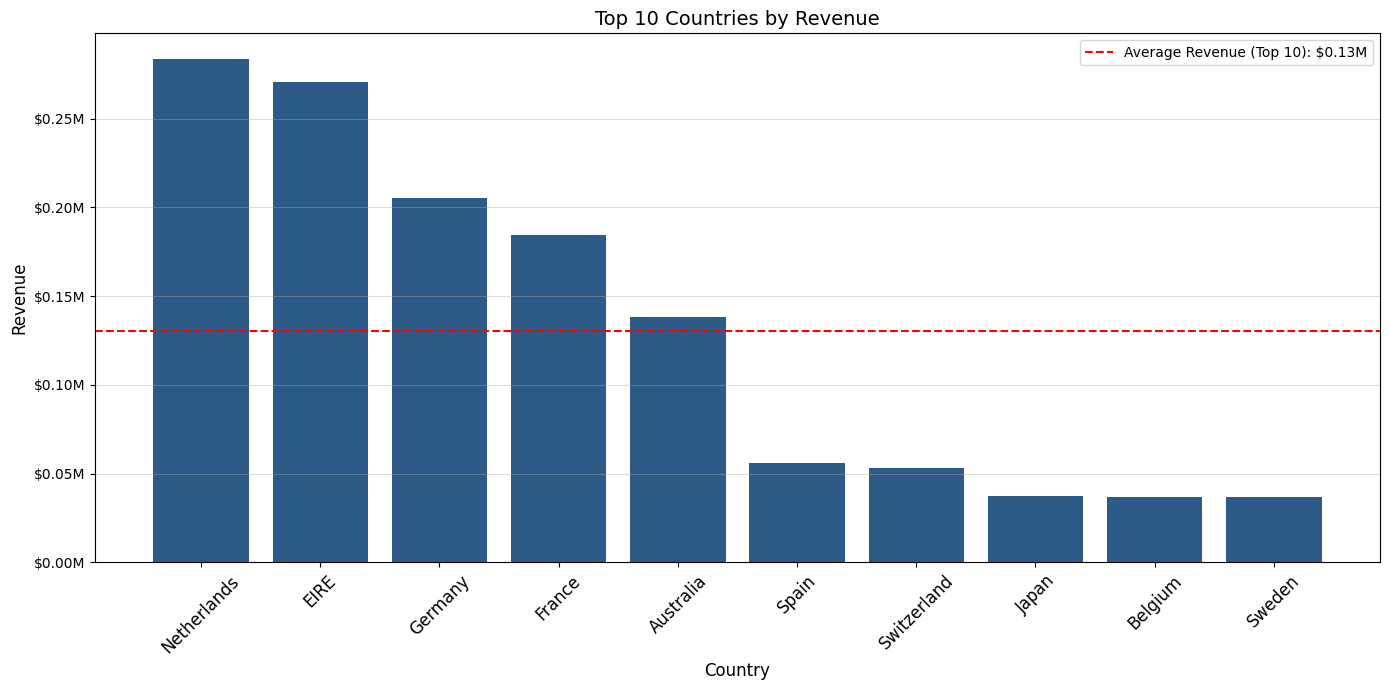

In [17]:
def millions_formatter(x, pos):
    """Format numbers as millions with 'M' suffix"""
    return f'${x/1e6:.2f}M'

#custom plotting colors 
BLUE = '#2E5A88'    
GRAY = '#7B8B8E'  
GREEN = '#5A8C5A' 
LIGHT_GRAY = '#F5F5F5'
#========================

#Only show top N
top_n = 10
top_countries = countries_performance.head(top_n)

plt.figure(figsize=(14, 7))
bars = plt.bar(top_countries['Country'], top_countries['total_revenue'], color=BLUE)
avg_revenue = top_countries['total_revenue'].mean()
plt.axhline(y=avg_revenue, color='red', linestyle='--', label=f'Average Revenue (Top {top_n}): ${avg_revenue/1e6:.2f}M')

plt.title(f'Top {top_n} Countries by Revenue', fontsize=14)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', alpha=0.6, linestyle='-', linewidth=0.5, color='darkgray')
#Apply custom formatter
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
# Display Top 10 Countries by revenue.
top_n = 10
top_countries = (countries_performance
                 .head(top_n)
                 .reset_index(drop = True))
print(f" - Top {top_n} Countries Analysis")
print(f" ----- Total Countries: {len(countries_performance)}----")
print(f" - Top {top_n} Revenue Share: {top_countries['revenue_pct'].sum():.1f}%")
print(f" - Top {top_n} Quantity Share: {top_countries['quantity_pct'].sum():.1f}%")
top_countries

 - Top 10 Countries Analysis
 ----- Total Countries: 37----
 - Top 10 Revenue Share: 85.5%
 - Top 10 Quantity Share: 87.1%


,Country,total_revenue,total_quantity,revenue_rank,quantity_rank,avg_price,revenue_pct,quantity_pct,revenue_cumulative,revenue_cumulative_pct
0,Netherlands,283889.34,200258,1,1,1.42,18.65,21.72,283889.34,18.65
1,EIRE,270800.76,146882,2,2,1.84,17.79,15.93,554690.10,36.43
2,Germany,205284.25,117990,3,3,1.74,13.48,12.79,759974.35,49.92
3,France,184465.25,111219,4,4,1.66,12.12,12.06,944439.60,62.03
4,Australia,138103.81,83890,5,5,1.65,9.07,9.10,1082543.41,71.10
5,Spain,55685.11,27715,6,8,2.01,3.66,3.01,1138228.52,74.76
6,Switzerland,53065.60,30515,7,7,1.74,3.49,3.31,1191294.12,78.24
7,Japan,37416.37,26016,8,9,1.44,2.46,2.82,1228710.49,80.70
8,Belgium,36927.34,22962,9,10,1.61,2.43,2.49,1265637.83,83.13
9,Sweden,36813.83,36033,10,6,1.02,2.42,3.91,1302451.66,85.54


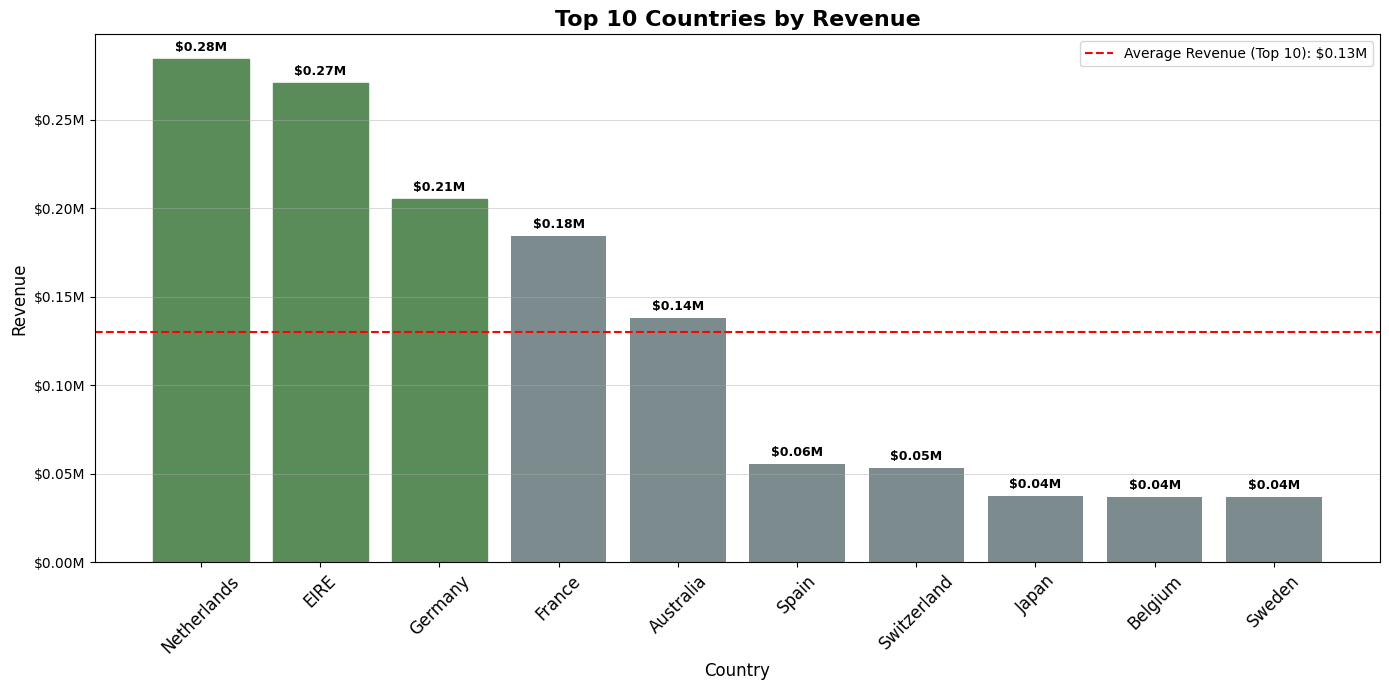

In [19]:
#Plot Top Ten Countries by Revenue
def millions_formatter(x, pos):
    """Format numbers as millions with 'M' suffix"""
    return f'${x/1e6:.2f}M'

def thousands_formatter(x, pos):
    """Format numbers as thousands with 'K' suffix"""
    return f'{x/1000:.2f}K'

#custom plotting colors 
BLUE = '#2E5A88'    
GRAY = '#7B8B8E'  
GREEN = '#5A8C5A' 
LIGHT_GRAY = '#F5F5F5'
#=======================
plt.figure(figsize=(14, 7))
bars = plt.bar(top_countries['Country'], top_countries['total_revenue'], color=GRAY)

#Color top 3 countries differently
for i, bar in enumerate(bars):
    if i < 3:
        bar.set_color(GREEN)

# Calculate average revenue for top N countries
avg_revenue = top_countries['total_revenue'].mean()
plt.axhline(y=avg_revenue, color='red', linestyle='--', label=f'Average Revenue (Top {top_n}): ${avg_revenue/1e6:.2f}M')

plt.title(f'Top {top_n} Countries by Revenue', fontsize=16, fontweight='bold')
plt.xlabel('Country', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', alpha=0.6, linestyle='-', linewidth=0.5, color='darkgray')
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
# Add labels on bars
for bar, (_, row) in zip(bars, top_countries.iterrows()):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (max(top_countries['total_revenue']) * 0.01),
             f'${height/1e6:.2f}M', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

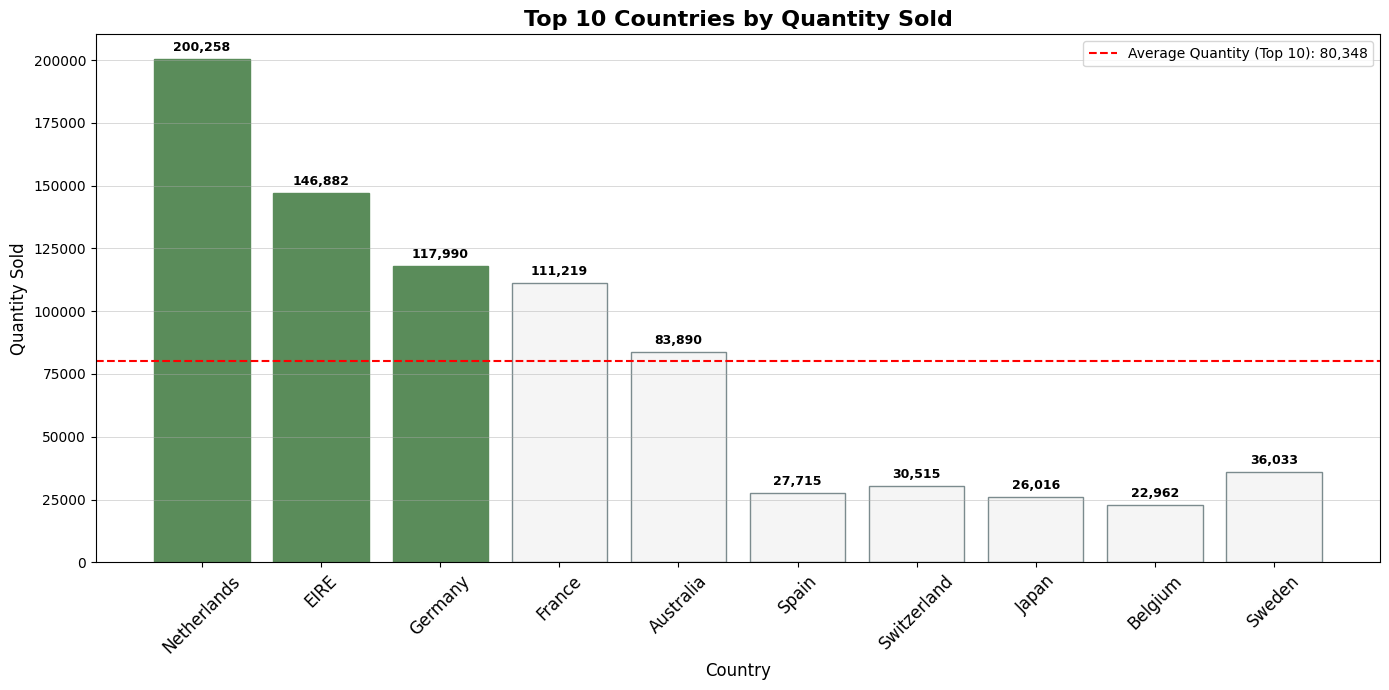

In [20]:
#Quanty sold by country
plt.figure(figsize=(14, 7))
bars_qty = plt.bar(top_countries['Country'], top_countries['total_quantity'], color=LIGHT_GRAY, edgecolor=GRAY)
# Color top 3
for i, bar in enumerate(bars_qty):
    if i < 3:
        bar.set_color(GREEN)
# Calculate average quantity for top N countries
avg_quantity = top_countries['total_quantity'].mean()
plt.axhline(y=avg_quantity, color='red', linestyle='--', 
            label=f'Average Quantity (Top {top_n}): {avg_quantity:,.0f}')

plt.title(f'Top {top_n} Countries by Quantity Sold', fontsize=16, fontweight='bold')
plt.xlabel('Country', fontsize=12)
plt.ylabel('Quantity Sold', fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', alpha=0.6, linestyle='-', linewidth=0.5, color='darkgray')
for bar, (_, row) in zip(bars_qty, top_countries.iterrows()):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (max(top_countries['total_quantity']) * 0.01),
             f'{height:,.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.legend(loc='upper right')
plt.tight_layout()
#plt.show()

In [21]:
# Revenue summary
print("\nRevenue Analysis:")
print(f"Total Revenue (Top {top_n}): ${top_countries['total_revenue'].sum()/1e6:.2f}M")
print(f"Average Revenue per Country: ${top_countries['total_revenue'].mean()/1e6:.2f}M")
print(f"Median Revenue: ${top_countries['total_revenue'].median()/1e6:.2f}M")
print(f"Revenue Range: ${top_countries['total_revenue'].min()/1e6:.2f}M to ${top_countries['total_revenue'].max()/1e6:.2f}M")


Revenue Analysis:
Total Revenue (Top 10): $1.30M
Average Revenue per Country: $0.13M
Median Revenue: $0.10M
Revenue Range: $0.04M to $0.28M


In [22]:
#Quantity Analysis
print(f"\nQantity Analysis:")
print(f"Total Quantity (Top {top_n}): {top_countries['total_quantity'].sum():,.0f}")
print(f"Average Quantity per Country: {top_countries['total_quantity'].mean():,.0f}")
print(f"Median Quantity: {top_countries['total_quantity'].median():,.0f}")
print(f"Quantity Range: {top_countries['total_quantity'].min():,.0f} to {top_countries['total_quantity'].max():,.0f}")


Qantity Analysis:
Total Quantity (Top 10): 803,480
Average Quantity per Country: 80,348
Median Quantity: 59,962
Quantity Range: 22,962 to 200,258


In [23]:
#Price Analysis
print(f"\nPrice Analysis:")
print(f"Average Price per Unit: ${top_countries['avg_price'].mean():.2f}")
print(f"Median Price per Unit: ${top_countries['avg_price'].median():.2f}")
print(f"Price Range: ${top_countries['avg_price'].min():.2f} to ${top_countries['avg_price'].max():.2f}")


Price Analysis:
Average Price per Unit: $1.61
Median Price per Unit: $1.65
Price Range: $1.02 to $2.01


In [24]:
# Performance insights
print(f"\nPerformance Insights:")
print(f"Top Revenue Country: {top_countries.iloc[0]['Country']} (${top_countries.iloc[0]['total_revenue']/1e6:.2f}M)")
print(f"Top Quantity Country: {top_countries.sort_values('total_quantity', ascending=False).iloc[0]['Country']} ({top_countries['total_quantity'].max():,.0f})")
print(f"Highest Avg Price: {top_countries.sort_values('avg_price', ascending=False).iloc[0]['Country']} (${top_countries['avg_price'].max():.2f})")


Performance Insights:
Top Revenue Country: Netherlands ($0.28M)
Top Quantity Country: Netherlands (200,258)
Highest Avg Price: Spain ($2.01)


### **Top Customers by Revenue**
- Rank all customers by total revenue
- Identify the top 10 highest-spending customers

In [29]:
#Top Customers by Revenue
#Fetch data from database
sqlGetCustomerSpending = """SELECT cust."CustomerID",txn."Quantity", cust."Country",txn."Revenue"
FROM online_retail.ecom_sales_transaction txn 
INNER JOIN online_retail.ecom_customer cust 
ON txn."CustomerID" = cust."CustomerID" AND txn."Country" = cust."Country"
"""
customerSpendingData = db_manager.select_data(sqlGetCustomerSpending)
customerSpendingData.head(2)

Query successful. Fetched 496072 rows.


,CustomerID,Quantity,Country,Revenue
0,17850,14,United Kingdom,37.30
1,17850,6,United Kingdom,25.50


In [26]:
customer_spending = (customerSpendingData
 #Customer ID is unique per country...
 .groupby(["CustomerID","Country"],as_index= False)
 .agg(total_revenue = ('Revenue','sum'),
      #total_quantity = ('Quantity','sum')
      )
 #Filter out sales from non customers
.query('CustomerID != 99999')
.assign(revenue_rank= lambda df_: df_.total_revenue.rank(ascending=False, method='dense').astype(int),
           revenue_pct= lambda df_: (df_.total_revenue / df_.total_revenue.sum()*100))
 .sort_values(by =['revenue_rank'],ascending= True)   
 .assign(revenue_cumulative = lambda df_: df_.total_revenue.cumsum(),
        revenue_cumulative_pct=lambda df_: (df_.revenue_cumulative / df_.total_revenue.sum()*100))
)
customer_spending

,CustomerID,Country,total_revenue,revenue_rank,revenue_pct,revenue_cumulative,revenue_cumulative_pct
1697,14646,Netherlands,279138.02,1,3.20,279138.02,3.20
4205,18102,United Kingdom,259657.30,2,2.97,538795.32,6.17
3733,17450,United Kingdom,194390.79,3,2.23,733186.11,8.39
3014,16446,United Kingdom,168472.50,4,1.93,901658.61,10.32
1887,14911,EIRE,136137.23,5,1.56,1037795.84,11.88
...,...,...,...,...,...,...,...
3328,16878,United Kingdom,13.30,4243,0.00,8734582.50,100.00
4102,17956,United Kingdom,12.75,4244,0.00,8734595.25,100.00
1801,14792,United Kingdom,6.20,4245,0.00,8734601.45,100.00
3020,16454,United Kingdom,5.90,4246,0.00,8734607.35,100.00


In [27]:
# Display Top 10 Customers by highest spending.
top_n = 10
top_customers = (customer_spending
                 .head(top_n)
                 .reset_index(drop = True))
print(f" - Top {top_n} Customers Analysis")
print(f" - Total Customers: {len(customer_spending)}")
print(f" - Top {top_n} Revenue Share: {top_customers['revenue_pct'].sum():.1f}%")
top_customers

 - Top 10 Customers Analysis
 - Total Customers: 4342
 - Top 10 Revenue Share: 17.4%


,CustomerID,Country,total_revenue,revenue_rank,revenue_pct,revenue_cumulative,revenue_cumulative_pct
0,14646,Netherlands,279138.02,1,3.20,279138.02,3.20
1,18102,United Kingdom,259657.30,2,2.97,538795.32,6.17
2,17450,United Kingdom,194390.79,3,2.23,733186.11,8.39
3,16446,United Kingdom,168472.50,4,1.93,901658.61,10.32
4,14911,EIRE,136137.23,5,1.56,1037795.84,11.88
5,12415,Australia,124564.53,6,1.43,1162360.37,13.31
6,14156,EIRE,116560.08,7,1.33,1278920.45,14.64
7,17511,United Kingdom,91062.38,8,1.04,1369982.83,15.68
8,12346,United Kingdom,77183.60,9,0.88,1447166.43,16.57
9,16029,United Kingdom,72708.09,10,0.83,1519874.52,17.40


### **Global Product Demand**
 - Compute total quantity sold per country
 - Remove the United Kingdom
 - Rank countries by demand and highlight high-opportunity markets

In [28]:
#Countries performance excluding UK
(countries_performance
.loc[:,["Country","total_revenue","total_quantity","quantity_pct","quantity_rank"]]
.sort_values(by =['quantity_rank'],ascending= True) 
)

,Country,total_revenue,total_quantity,quantity_pct,quantity_rank
24,Netherlands,283889.34,200258,21.72,1
10,EIRE,270800.76,146882,15.93,2
14,Germany,205284.25,117990,12.79,3
13,France,184465.25,111219,12.06,4
0,Australia,138103.81,83890,9.10,5
32,Sweden,36813.83,36033,3.91,6
33,Switzerland,53065.60,30515,3.31,7
31,Spain,55685.11,27715,3.01,8
20,Japan,37416.37,26016,2.82,9
3,Belgium,36927.34,22962,2.49,10


 - **Netherlands** dominates demand share outside UK with 21.7 % share and ranking 1st followed by **Ireland (EIRE)** and **Germany** at 15.9% and 12.7% repectively.  Clear opportunity for these mature narkets is continued deep penetration and defending dominance.

 - **Nordics** (Sweden, Norway, Finland, Denmark) represent an untapped premium Segment. These countries collectively show high average prices (e.g., Denmark 2.22, Sweden 1.02) and their high GDP per capita presents a clear opportunity to further tap into and expand the premium product segment.
- The numerous smaller markets from rank ~15 downwards (e.g., **Italy, Cyprus, Hong Kong, Singapore, and all below**) represent significant optionality. Focusing on scaling these many smaller markets offers a clear vector for substantial expansion.